In [1]:
import math, random, re, json, os, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from sacrebleu.metrics import BLEU

from generator import LLMEngine, ModelConfig, DecodeConfig

plt.rcParams["figure.dpi"] = 130

/home/ali/VSCodeProjects/iasd/llm-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
GLOBAL_SEED = 44
MAX_NEW_TOKENS = 100

# MODEL_ID = "gpt2-large"
MODEL_ID = "Qwen/Qwen3-0.6B-Base"

SWEEP_T = [0.5, 0.7, 0.9, 1.0, 1.2]
SWEEP_K = [1, 10, 40, 160, 640]
SWEEP_P = [0.85, 0.90, 0.95, 0.97, 0.99]
SWEEP_BEAMS = [1, 2, 4, 8, 16]

N_PROMPTS_GEN = 8      # reduce to fit 6GB comfortably
N_PROMPTS_PPL = 8      # smaller because scoring is expensive

MICROBATCH = 8          # key VRAM control: number of prompts per generate() call

def seed_everything(seed=GLOBAL_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything()

In [3]:
PROMPTS_PATH = "prompts_openwebtext_subset.json"

gpt2_tok = AutoTokenizer.from_pretrained("gpt2-large", use_fast=True)

def first_paragraph(text: str) -> str:
    text = (text or "").strip()
    if not text:
        return ""
    parts = re.split(r"\n\s*\n", text)
    para = parts[0].strip() if parts else ""
    return para if para else text.split("\n")[0].strip()

def make_prompt_from_para(para: str, min_tok=1, max_tok=40) -> str:
    ids = gpt2_tok(para, add_special_tokens=False).input_ids
    if len(ids) < min_tok:
        return ""
    L = random.randint(min_tok, min(max_tok, len(ids)))
    return gpt2_tok.decode(ids[:L])

if os.path.exists(PROMPTS_PATH):
    with open(PROMPTS_PATH, "r", encoding="utf-8") as f:
        prompts = json.load(f)
else:
    ds = load_dataset(
        "dylanebert/openwebtext",
        split="train",
        streaming=True,
        revision="refs/convert/parquet",
    )
    ds = ds.shuffle(seed=GLOBAL_SEED, buffer_size=50_000)

    docs = [ex["text"] for ex in ds.take(1200)]
    prompts = []
    for txt in docs:
        pr = make_prompt_from_para(first_paragraph(txt), 1, 40)
        if pr:
            prompts.append(pr)
        if len(prompts) >= max(N_PROMPTS_GEN, N_PROMPTS_PPL):
            break

    with open(PROMPTS_PATH, "w", encoding="utf-8") as f:
        json.dump(prompts, f, ensure_ascii=False, indent=2)

prompts_gen = prompts[:N_PROMPTS_GEN]
prompts_ppl = prompts[:N_PROMPTS_PPL]

len(prompts_gen), len(prompts_ppl), prompts_gen[0]

(8,
 8,
 'NuCoal Resources have suffered another blow after their case against the')

In [4]:
def make_engine(model_id: str) -> LLMEngine:
    return LLMEngine(ModelConfig(model_id=model_id))

def dcfg(method: str, t=1.0, k=0, p=1.0, num_beams=1, seed=GLOBAL_SEED) -> DecodeConfig:
    return DecodeConfig(
        method=method,
        max_new_tokens=MAX_NEW_TOKENS,
        t=t,
        k=k,
        p=p,
        num_beams=num_beams,
        seed=seed,
    )

engine = make_engine(MODEL_ID)

In [5]:
def generate_microbatched(text_list, decode_cfg, microbatch=MICROBATCH):
    outs = []
    for i in range(0, len(text_list), microbatch):
        chunk = text_list[i:i+microbatch]
        chunk_out = engine.generate(text_list=chunk, dcfg=decode_cfg)
        outs.extend(list(chunk_out))
        if torch.cuda.is_available():
            torch.cuda.empty_cache()  # helps with fragmentation on small GPUs
    return outs

In [6]:
bleu = BLEU(effective_order=True)

def word_tokens(s: str):
    return re.findall(r"\w+|[^\w\s]", (s or "").lower(), flags=re.UNICODE)

def has_repeated_suffix(text: str, min_ng=2, max_ng=20, min_rep=3) -> bool:
    toks = word_tokens(text)
    L = len(toks)
    if L < min_ng * min_rep:
        return False
    max_ng = min(max_ng, L // min_rep)
    for n in range(min_ng, max_ng + 1):
        unit = toks[-n:]
        for r in range(min_rep, L // n + 1):
            if toks[-n*r:] == unit * r:
                return True
    return False

def distinct_trigrams(text: str) -> int:
    toks = word_tokens(text)
    if len(toks) < 3:
        return 0
    return len({tuple(toks[i:i+3]) for i in range(len(toks)-2)})

def approx_self_bleu(texts, n_eval=120, n_refs=30, seed=GLOBAL_SEED) -> float:
    rng = random.Random(seed)
    N = len(texts)
    idxs = list(range(N))
    rng.shuffle(idxs)
    idxs = idxs[:min(n_eval, N)]
    scores = []
    for i in idxs:
        hyp = texts[i]
        pool = [texts[j] for j in range(N) if j != i]
        if not pool:
            continue
        refs = pool if len(pool) <= n_refs else rng.sample(pool, n_refs)
        scores.append(bleu.sentence_score(hyp, refs).score / 100.0)
    return float(np.mean(scores)) if scores else float("nan")

In [7]:
ppl_tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, trust_remote_code=True)
if ppl_tok.pad_token is None:
    ppl_tok.pad_token = ppl_tok.eos_token

ppl_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    dtype=torch.float32,
    device_map=None,
    trust_remote_code=True,
).to("cpu").eval()

@torch.no_grad()
def continuation_ppl(prompt: str, full_text: str) -> float:
    p_ids = ppl_tok(prompt, return_tensors="pt").input_ids[0]
    x_ids = ppl_tok(full_text, return_tensors="pt").input_ids[0]
    if len(x_ids) <= len(p_ids):
        return float("inf")

    ctx_len = len(p_ids)
    inp = x_ids.unsqueeze(0)

    logits = ppl_model(inp).logits
    logp = torch.log_softmax(logits[:, :-1, :], dim=-1)
    tgt = inp[:, 1:]

    start = max(ctx_len - 1, 0)
    lp = logp[:, start:, :].gather(-1, tgt[:, start:].unsqueeze(-1)).squeeze(-1)

    nll = -lp.mean().item()
    return math.exp(nll) if nll < 50 else float("inf")

In [8]:
def run_family(family: str, xs: list):
    rows = []
    for x in tqdm(xs, desc=f"{MODEL_ID} {family}"):
        if family == "temperature":
            cfg = dcfg("temperature", t=float(x))
        elif family == "top_k":
            cfg = dcfg("top_k", k=int(x))
        elif family == "top_p":
            cfg = dcfg("top_p", p=float(x))
        else:
            raise ValueError(family)

        texts = generate_microbatched(prompts_gen, cfg, microbatch=MICROBATCH)

        repeat_rate = float(np.mean([has_repeated_suffix(t) for t in texts]))
        self_bleu = approx_self_bleu(texts)

        texts_ppl = texts[:len(prompts_ppl)]
        ppl = float(np.mean([continuation_ppl(p, t) for p, t in zip(prompts_ppl, texts_ppl)]))

        rows.append({"model_id": MODEL_ID, "family": family, "x": x,
                     "ppl": ppl, "repeat_rate": repeat_rate, "self_bleu": self_bleu})
    return pd.DataFrame(rows)

df_main = pd.concat([
    run_family("temperature", SWEEP_T),
    run_family("top_k", SWEEP_K),
    run_family("top_p", SWEEP_P),
], ignore_index=True)

df_main

Qwen/Qwen3-0.6B-Base temperature:   0%|          | 0/5 [00:00<?, ?it/s]

Qwen/Qwen3-0.6B-Base top_p: 100%|██████████| 5/5 [01:33<00:00, 18.63s/it]


,model_id,family,x,ppl,repeat_rate,self_bleu
0,Qwen/Qwen3-0.6B-Base,temperature,0.50,3.124117,0.00,0.026927
1,Qwen/Qwen3-0.6B-Base,temperature,0.70,4.928099,0.00,0.030205
2,Qwen/Qwen3-0.6B-Base,temperature,0.90,11.917820,0.00,0.021077
3,Qwen/Qwen3-0.6B-Base,temperature,1.00,23.808629,0.00,0.021548
4,Qwen/Qwen3-0.6B-Base,temperature,1.20,613.271189,0.00,0.015320
5,Qwen/Qwen3-0.6B-Base,top_k,1.00,2.038286,0.25,0.023848
6,Qwen/Qwen3-0.6B-Base,top_k,10.00,6.032093,0.00,0.022863
7,Qwen/Qwen3-0.6B-Base,top_k,40.00,8.234609,0.00,0.028771
8,Qwen/Qwen3-0.6B-Base,top_k,160.00,12.625645,0.00,0.019964
9,Qwen/Qwen3-0.6B-Base,top_k,640.00,18.633150,0.00,0.017618


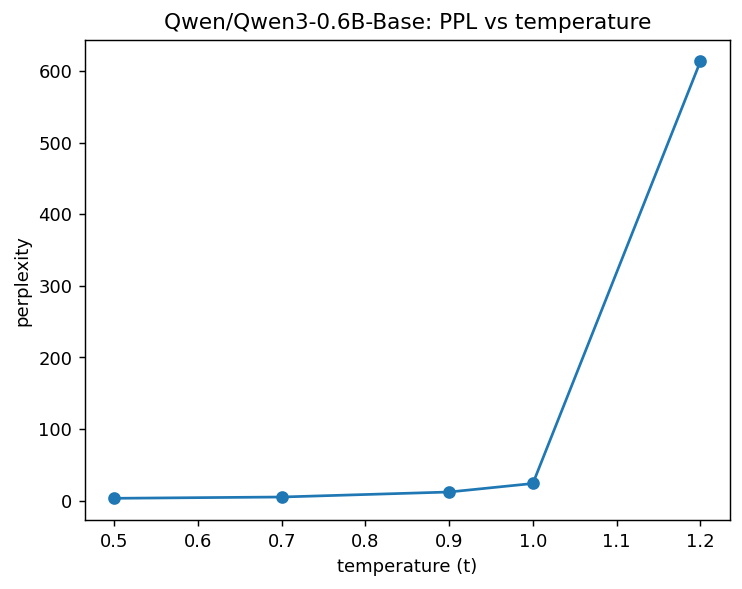

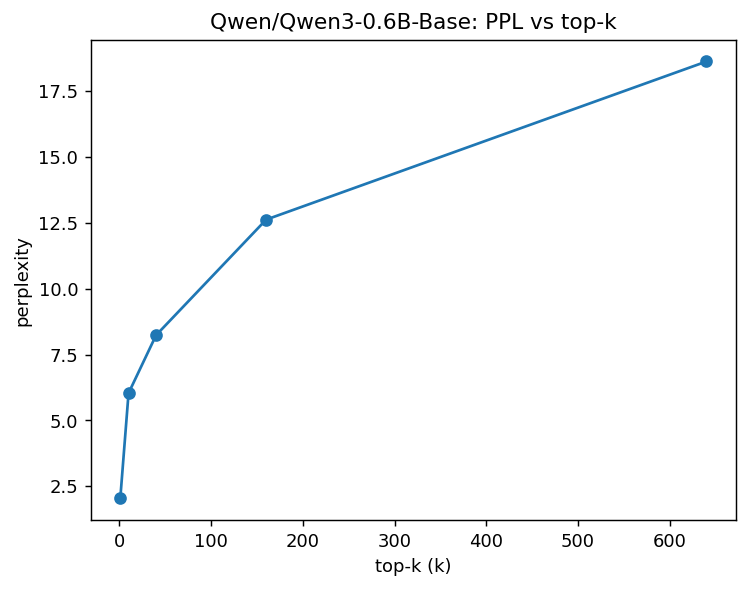

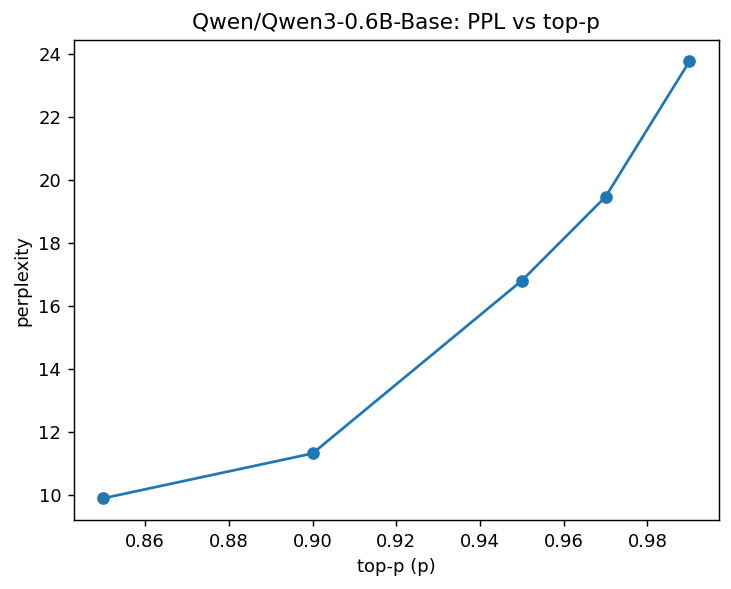

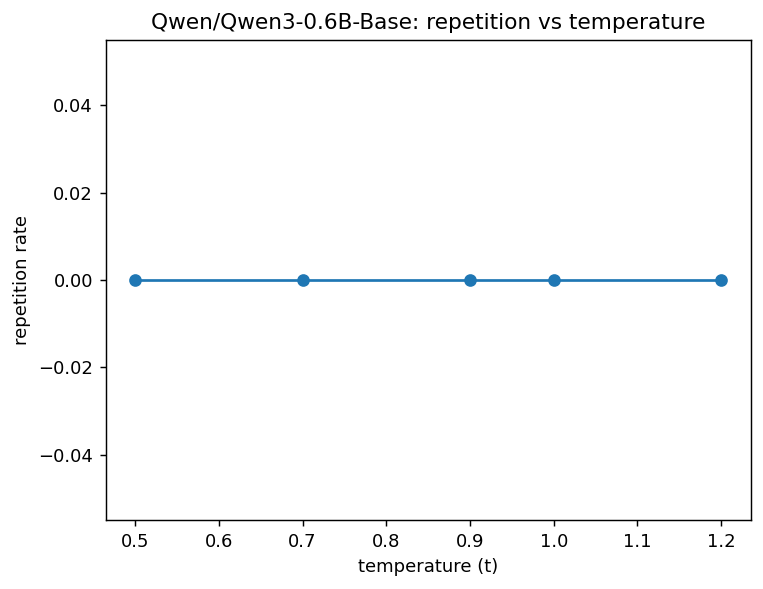

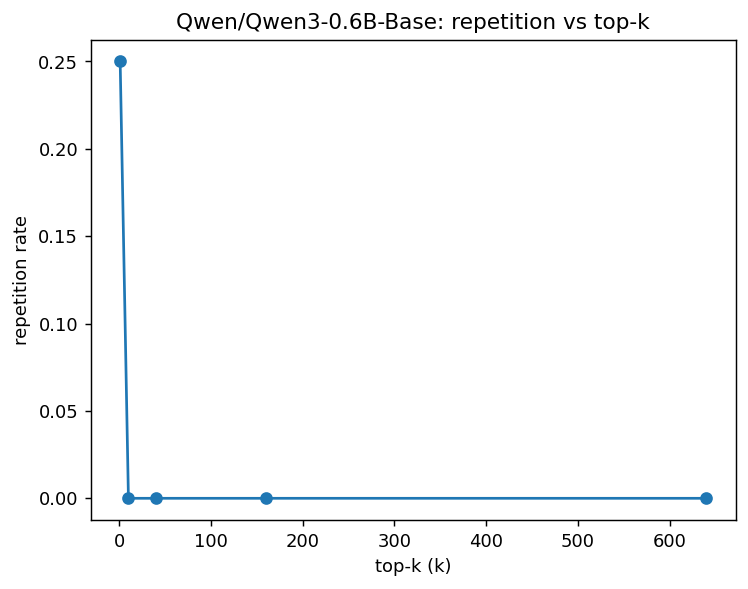

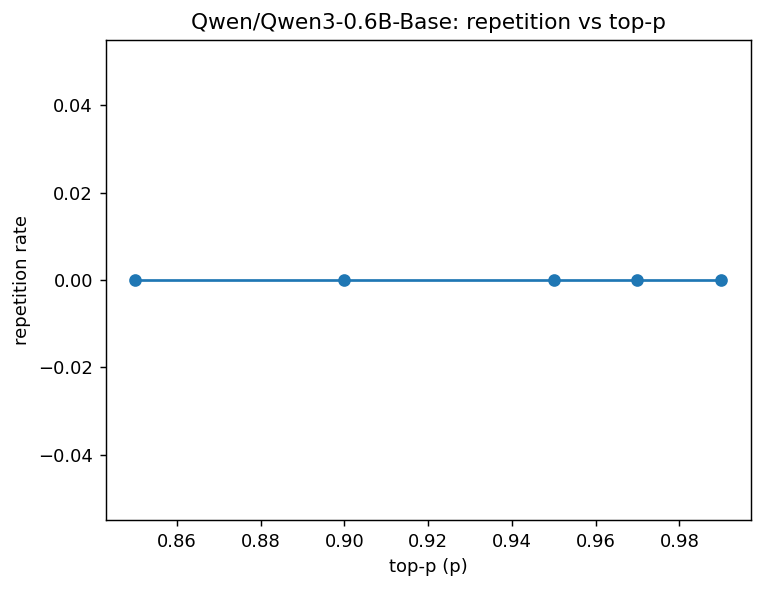

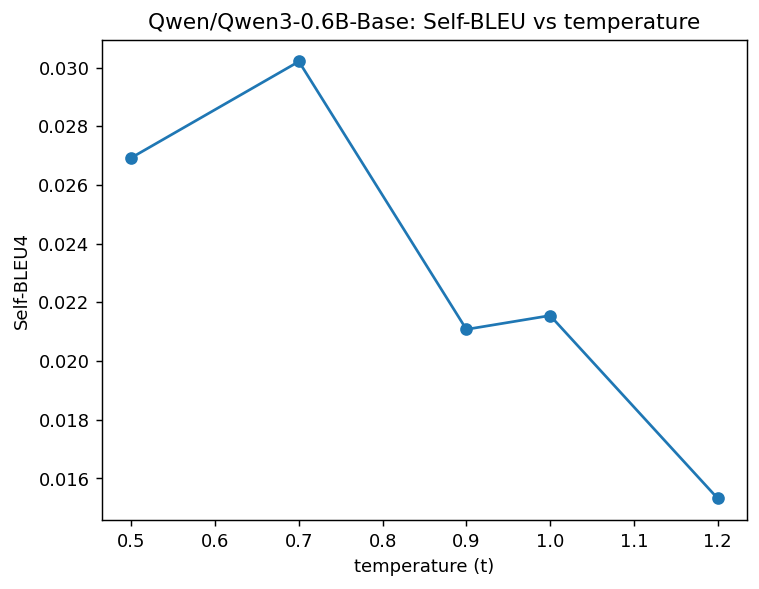

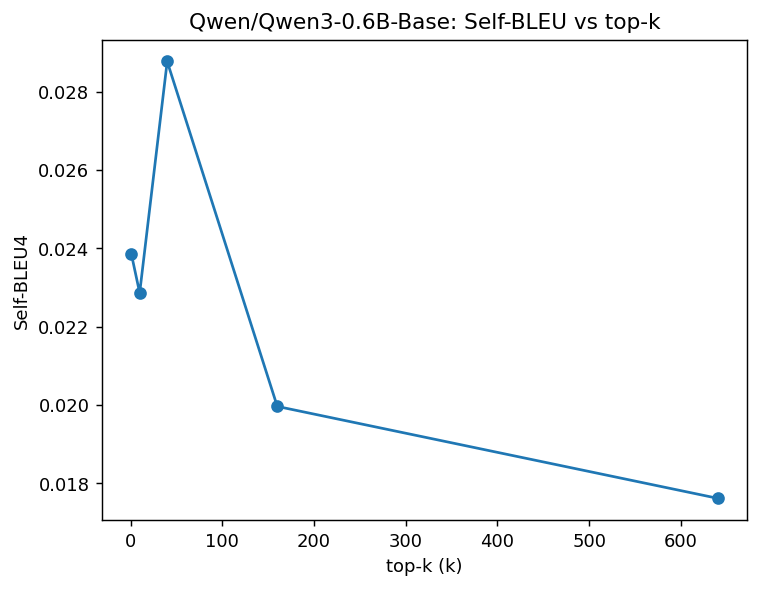

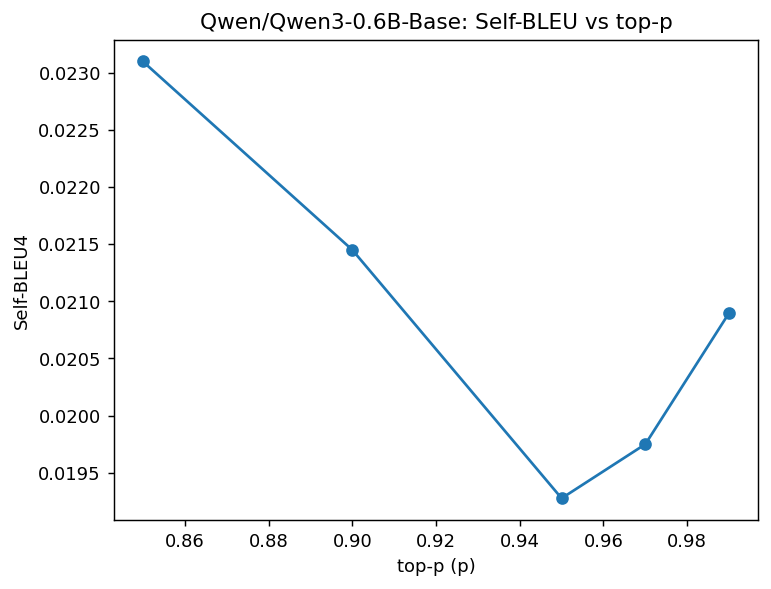

In [9]:
def plot_metric(df, family, y, xlab, ylab, title):
    sub = df[df.family == family].sort_values("x")
    plt.figure()
    plt.plot(sub["x"], sub[y], marker="o")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()

plot_metric(df_main, "temperature", "ppl", "temperature (t)", "perplexity", f"{MODEL_ID}: PPL vs temperature")
plot_metric(df_main, "top_k", "ppl", "top-k (k)", "perplexity", f"{MODEL_ID}: PPL vs top-k")
plot_metric(df_main, "top_p", "ppl", "top-p (p)", "perplexity", f"{MODEL_ID}: PPL vs top-p")

plot_metric(df_main, "temperature", "repeat_rate", "temperature (t)", "repetition rate", f"{MODEL_ID}: repetition vs temperature")
plot_metric(df_main, "top_k", "repeat_rate", "top-k (k)", "repetition rate", f"{MODEL_ID}: repetition vs top-k")
plot_metric(df_main, "top_p", "repeat_rate", "top-p (p)", "repetition rate", f"{MODEL_ID}: repetition vs top-p")

plot_metric(df_main, "temperature", "self_bleu", "temperature (t)", "Self-BLEU4", f"{MODEL_ID}: Self-BLEU vs temperature")
plot_metric(df_main, "top_k", "self_bleu", "top-k (k)", "Self-BLEU4", f"{MODEL_ID}: Self-BLEU vs top-k")
plot_metric(df_main, "top_p", "self_bleu", "top-p (p)", "Self-BLEU4", f"{MODEL_ID}: Self-BLEU vs top-p")

In [10]:
# del engine
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

23101

In [11]:
len_tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, trust_remote_code=True)

def tok_len(text: str) -> int:
    return len(len_tok(text, add_special_tokens=False).input_ids)

STOP_EARLY_FRAC = 0.2
rows = []

for b in tqdm(SWEEP_BEAMS, desc=f"{MODEL_ID} beam_search"):
    cfg = dcfg("beam_search", num_beams=int(b))
    texts = generate_microbatched(prompts_gen, cfg, microbatch=MICROBATCH)

    new_lens = []
    trigs = []
    stops = []

    for pr, tx in zip(prompts_gen, texts):
        new_len = max(tok_len(tx) - tok_len(pr), 0)
        new_lens.append(new_len)
        trigs.append(distinct_trigrams(tx))
        stops.append(new_len < int(STOP_EARLY_FRAC * MAX_NEW_TOKENS))

    rows.append({
        "model_id": MODEL_ID,
        "beams": b,
        "avg_new_tokens": float(np.mean(new_lens)),
        "avg_distinct_trigrams": float(np.mean(trigs)),
        "stop_early_rate": float(np.mean(stops)),
    })
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

df_beam = pd.DataFrame(rows)
df_beam


Qwen/Qwen3-0.6B-Base beam_search: 100%|██████████| 5/5 [00:46<00:00,  9.39s/it]


,model_id,beams,avg_new_tokens,avg_distinct_trigrams,stop_early_rate
0,Qwen/Qwen3-0.6B-Base,1,100.0,66.500,0.0
1,Qwen/Qwen3-0.6B-Base,2,100.0,69.750,0.0
2,Qwen/Qwen3-0.6B-Base,4,100.0,61.875,0.0
3,Qwen/Qwen3-0.6B-Base,8,100.0,60.250,0.0
4,Qwen/Qwen3-0.6B-Base,16,100.0,69.375,0.0


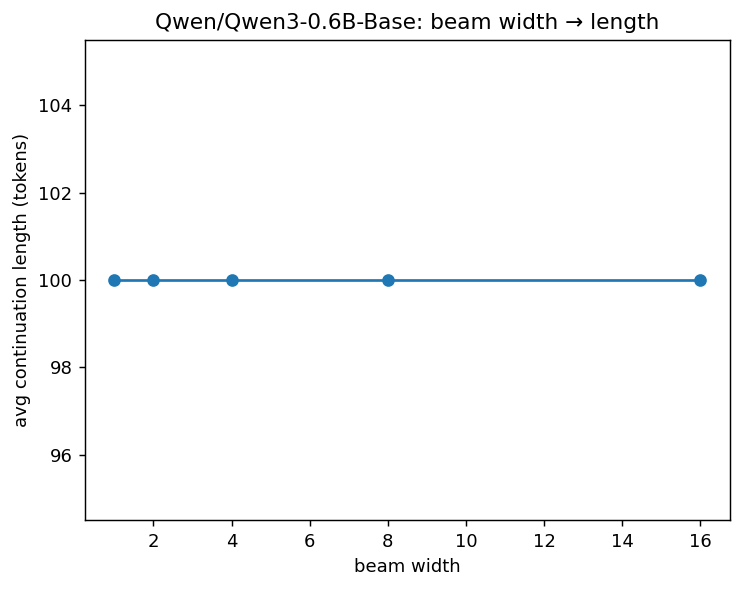

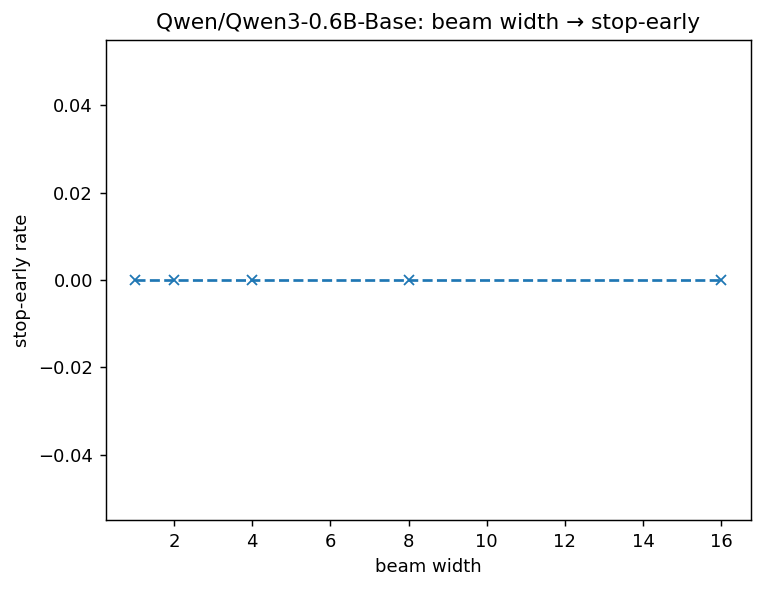

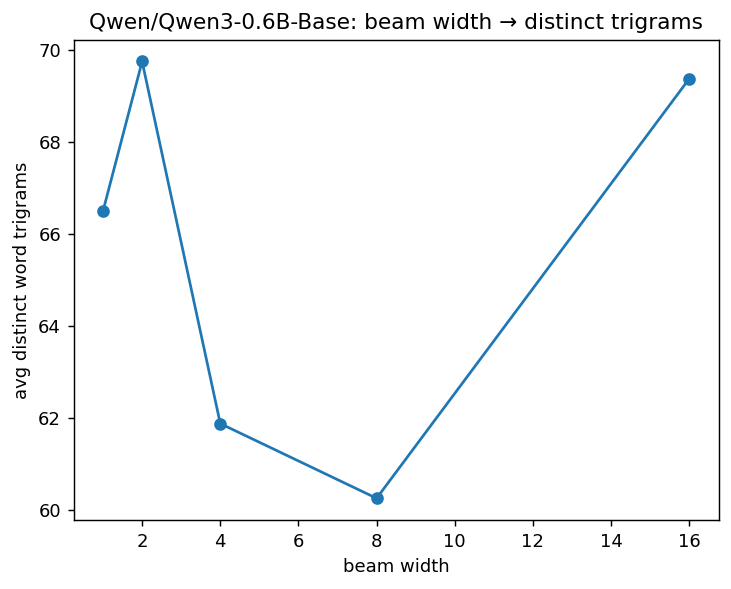

In [12]:
plt.figure()
plt.plot(df_beam["beams"], df_beam["avg_new_tokens"], marker="o")
plt.xlabel("beam width")
plt.ylabel("avg continuation length (tokens)")
plt.title(f"{MODEL_ID}: beam width → length")
plt.show()

plt.figure()
plt.plot(df_beam["beams"], df_beam["stop_early_rate"], marker="x", linestyle="--")
plt.xlabel("beam width")
plt.ylabel("stop-early rate")
plt.title(f"{MODEL_ID}: beam width → stop-early")
plt.show()

plt.figure()
plt.plot(df_beam["beams"], df_beam["avg_distinct_trigrams"], marker="o")
plt.xlabel("beam width")
plt.ylabel("avg distinct word trigrams")
plt.title(f"{MODEL_ID}: beam width → distinct trigrams")
plt.show()

In [ ]:
safe = MODEL_ID.replace("/", "__")
df_main.to_csv(f"results_main__{safe}.csv", index=False)
df_beam.to_csv(f"results_beam__{safe}.csv", index=False)